# Experiment and path specification

In [21]:
# Specify the experiment for analysis
experiment='cxilu9218'
runNumber = 73

# Set the installation and output path
import os
os.environ['INSTALLPATH']= '/cds/home/i/igabalsk/TRXS-Run18'
os.environ['OUTPUTPATH']= '/cds/data/psdm/%s/%s/scratch' % (experiment[0:3],experiment)

# Import Libraries

In [22]:
# Magic iPython command to enable plotting
%matplotlib inline

# Load in the pythonBatchMagic library
import sys
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic')
from pythonBatchMagic import *

# Determine current user
currentUser, error = unixCMD("echo $USER")
currentUser = currentUser.strip()
print(currentUser)
os.environ['RESULTSPATH']= ('/cds/data/psdm/%s/%s/results/%s' % (experiment[0:3],experiment,currentUser)).strip()
if not os.path.exists(os.environ['RESULTSPATH']):
    os.mkdir(os.environ['RESULTSPATH'])

igabalsk


# Leveraging the batch queue to quickly grab point data

## Loading libraries

In [23]:
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/LCLS')
from LCLSdefault import *

sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/mattsLibraries')
from picklez import *

# Load in the get data library
from dataAnalysis import *

# Load in the batch library for lcls
from lclsBatch import *

## Grabbing point data across nodes

In [24]:
detDict = {
    'uvint':{'name': 'Acqiris','get-function':'getAcqirisSum2'},
           'uvint1':{'name': 'Acqiris','get-function':'getAcqirisSum1'},
           'xrayEnergy':{'name':'FEEGasDetEnergy','get-function': 'getXrayEnergy' },
        'gasPressure':{'name': 'CXI:MKS670:READINGGET','get-function':'getGasPressure'},
           'ebeamcharge':{'name':'EBeam', 'get-function': 'getEbeamCharge'},
          'stageencoder':{'name':'CXI:LAS:MMN:04.RBV','get-function':'getStageEncoder'},
          'ttfltpos':{'name':'CXI:TIMETOOL:FLTPOS', 'get-function': 'getTTFltPos'},
          'vitpos':{'name':'LAS:FS5:VIT:FS_TGT_TIME_DIAL', 'get-function': 'getTTFltPos'},
           'xint':{'name':'CxiDg3_Imb01','get-function': 'getIPM' },
           'xpos':{'name':'CxiDg3_Imb01','get-function': 'getXPos' },
           'ypos':{'name':'CxiDg3_Imb01','get-function': 'getYPos' },
          'seconds':{'name':'seconds', 'get-function': 'getSeconds'},
          'nanoseconds':{'name':'nanonseconds', 'get-function': 'getNanoseconds'},
          'fiducials':{'name':'fiducials', 'get-function': 'getFiducials'},
        'dg2wave8':{'name':'CXI:DG2:BMMON:SUM', 'get-function':'getWave8'},
          'laserOn':{'name':'evr1', 'get-function': 'getLaserOn'},
          'xrayOn':{'name':'evr1', 'get-function': 'getXrayOn'}
}
print detDict.keys()
NSHOTS = 64000
ngrab = 640
rank = int( float(NSHOTS)/float(ngrab) )
print('Grabbing %d shots, %d events at a time, on %d nodes' %(NSHOTS,ngrab,rank))
batchThreads = batchPointDataGrabber( detDict, eventMax=int(rank*ngrab), experiment=experiment, runNumber=runNumber, rank=int(rank) )
# batchThreads.Queue = 'psanaq'
batchThreads.Queue = 'psanaq'
batchThreads.RunType = 'mpirun python2'
batchThreads.start()

['dg2wave8', 'xpos', 'uvint1', 'seconds', 'nanoseconds', 'xint', 'ypos', 'fiducials', 'ttfltpos', 'xrayOn', 'stageencoder', 'vitpos', 'gasPressure', 'ebeamcharge', 'uvint', 'xrayEnergy', 'laserOn']
Grabbing 64000 shots, 640 events at a time, on 100 nodes
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/pointData-run73-temp0.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/pointData-run73-temp0.py; exit'
Output: Job <403343> is submitted to queue <psanaq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Outpu

Output: Job <403422> is submitted to queue <psanaq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/pointData-run73-temp16.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/pointData-run73-temp16.py; exit'
Output: Job <403429> is submitted to queue <psanaq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/pointData-run73-temp17.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/pointData-run

Exception in thread Thread-136:
Traceback (most recent call last):
  File "/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/pythonBatchMagic.py", line 281, in run
    OutputName=self.OutputName)
  File "/cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/pythonBatchMagic.py", line 221, in SubmitBatchJob
    return extractJobId( str(output) )
  File "/cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/pythonBatchMagic.py", line 104, in extractJobId
    return m.group(0)[1:-1]
AttributeError: 'NoneType' object has no attribute 'group'



Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/pointData-run73-temp29.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/pointData-run73-temp29.py; exit'
Output: Job <403507> is submitted to queue <psanaq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/pointData-run73-temp30.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/pointData-run73-temp30.py; exit'
Output: Job <403512> is submitted to queue

Output: Job <403603> is submitted to queue <psanaq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/pointData-run73-temp46.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/pointData-run73-temp46.py; exit'
Output: Job <403607> is submitted to queue <psanaq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/pointData-run73-temp47.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/pointData-run

Output: Job <403706> is submitted to queue <psanaq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/pointData-run73-temp63.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/pointData-run73-temp63.py; exit'
Output: Job <403712> is submitted to queue <psanaq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/pointData-run73-temp64.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/pointData-run

Output: Job <403794> is submitted to queue <psanaq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/pointData-run73-temp79.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/pointData-run73-temp79.py; exit'
Output: Job <403799> is submitted to queue <psanaq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/pointData-run73-temp80.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/pointData-run

Exception in thread Thread-193:
Traceback (most recent call last):
  File "/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/pythonBatchMagic.py", line 281, in run
    OutputName=self.OutputName)
  File "/cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/pythonBatchMagic.py", line 221, in SubmitBatchJob
    return extractJobId( str(output) )
  File "/cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/pythonBatchMagic.py", line 104, in extractJobId
    return m.group(0)[1:-1]
AttributeError: 'NoneType' object has no attribute 'group'



Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/pointData-run73-temp86.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/pointData-run73-temp86.py; exit'
Output: Job <403843> is submitted to queue <psanaq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/pointData-run73-temp87.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/pointData-run73-temp87.py; exit'
Output: Job <403848> is submitted to queue

## Check job status

In [10]:
stdoutdata, stderrdata = bjobs()
print stdoutdata
print stderrdata


No unfinished job found



## Kill threads if they die

In [25]:
batchThreads.requestStop()
time.sleep(5)
stdoutdata, stderrdata = bkill(killAll=True)
print stdoutdata
print stderrdata

Job <402209> is being terminated
Job <402215> is being terminated
Job <403433> is being terminated
Job <403525> is being terminated
Job <403530> is being terminated
Job <403541> is being terminated
Job <403548> is being terminated
Job <403607> is being terminated
Job <403625> is being terminated
Job <403631> is being terminated
Job <403706> is being terminated
Job <403712> is being terminated
Job <403724> is being terminated
Job <403725> is being terminated
Job <403780> is being terminated
Job <403794> is being terminated
Job <403820> is being terminated
Job <403826> is being terminated
Job <403866> is being terminated
Job <403868> is being terminated
Job <403878> is being terminated
Job <403893> is being terminated

Job <403353>: Job has already finished
Job <403799>: Job has already finished



In [11]:
batchThreads.status

'Finished'

In [12]:
batchThreads.gather()

/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/nodePointDataGrabber0-run-18 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/nodePointDataGrabber1-run-18 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/nodePointDataGrabber2-run-18 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/nodePointDataGrabber3-run-18 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/nodePointDataGrabber4-run-18 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/nodePointDataGrabber5-run-18 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/nodePointDataGrabber6-run-18 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/nodePointDataGrabber7-run-18 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/nodePointDataGrabber8-run-18 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/nodePointDataGrabber9-run-18 remembered!


## Drop empty array values

In [13]:
pointData = batchThreads.detArrays

def dropEmpty(pointData):

    filledBin = (pointData['seconds'] > 0)    

    for key in pointData.keys():
        pointData[key]=pointData[key][filledBin] 
        
    return pointData

def dropNaN(pointData):
    goodBin = np.ones(pointData['seconds'].shape, dtype=bool)
    for key in pointData.keys():
        goodBin = goodBin & ~np.isnan(pointData[key])
    for key in pointData.keys():
        pointData[key]=pointData[key][goodBin]
    return pointData
print len(pointData['seconds'])
pointData_masked = dropNaN(dropEmpty(pointData))
print 'Number of good shots: ', len(pointData_masked['seconds'])

9600
Number of good shots:  5904


## Save point data

In [14]:
from scipy.io import savemat
save_obj( pointData_masked, os.environ['RESULTSPATH']+'/pointData-run-%d' % runNumber )
savemat(os.environ['RESULTSPATH']+'/pointData-run-%d' % runNumber, pointData_masked)

## Plot histogram of result

/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


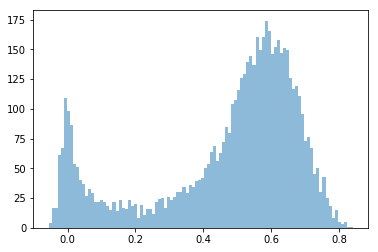

In [15]:
detArrays = pointData_masked

# print detArrays['ttfltpos'].min()
fig2, ax2 = plt.subplots(1, 1)
ax2.hist(detArrays['xrayEnergy'], bins=100,normed=False, alpha=0.5);

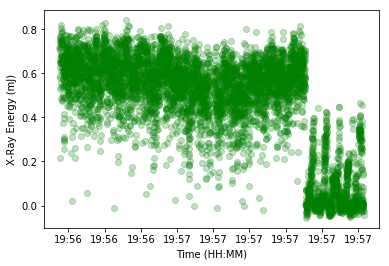

In [16]:
import datetime
import matplotlib.dates as dates
def getLabtime(second, microseconds):
    refdate = datetime.datetime(1970,1,1)
    td = datetime.timedelta(seconds=second,microseconds=microseconds)
    return refdate+td
labtime = np.array([getLabtime( s, float(ns)/1000. ) for s,ns in zip(detArrays['seconds'],detArrays['nanoseconds'])])
fig,ax= plt.subplots()
date_form = dates.DateFormatter('%H:%M', tz=None)
ax.plot(labtime, detArrays['xrayEnergy'],'go',alpha=0.25)
ax.xaxis.set_major_formatter(date_form)
plt.xlabel('Time (HH:MM)')
plt.ylabel('X-Ray Energy (mJ)');